In [1]:
# Importamos librerias
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import copy
from collections import namedtuple
import os
import random
import shutil
import time
from PIL import Image

In [2]:
# Semilla aleatoria para poder tener resultados replicables
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
# Descargamos el dataset desde kaggle con mi api key

!pip install kaggle
!kaggle datasets download mamun1113/doctors-handwritten-prescription-bd-dataset --unzip

os.environ['KAGGLE_USERNAME'] = 'ajoshuarg'
os.environ['KAGGLE_KEY'] = '0cd46a5f21a3fa21b4a97708492c9fba'

Dataset URL: https://www.kaggle.com/datasets/mamun1113/doctors-handwritten-prescription-bd-dataset
License(s): ODbL-1.0




  0%|          | 0.00/19.1M [00:00<?, ?B/s]
  5%|▌         | 1.00M/19.1M [00:00<00:11, 1.59MB/s]
 10%|█         | 2.00M/19.1M [00:00<00:05, 3.12MB/s]
 21%|██        | 4.00M/19.1M [00:00<00:02, 6.63MB/s]
 37%|███▋      | 7.00M/19.1M [00:01<00:01, 10.6MB/s]
 47%|████▋     | 9.00M/19.1M [00:01<00:00, 10.8MB/s]
 63%|██████▎   | 12.0M/19.1M [00:01<00:00, 14.5MB/s]
 73%|███████▎  | 14.0M/19.1M [00:01<00:00, 14.5MB/s]
100%|██████████| 19.1M/19.1M [00:01<00:00, 12.6MB/s]


In [63]:
!mv 'Doctor’s Handwritten Prescription BD dataset' BD_handwrite

'mv' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
# Definimos los directorios

original_training_words_dir = "BD_handwrite/Training/training_words"
training_words_csv = "BD_handwrite/Training/training_labels.csv"
original_testing_words_dir = "BD_handwrite/Testing/testing_words"
testing_words_csv = "BD_handwrite/Testing/testing_labels.csv"
original_validation_words_dir = "BD_handwrite/Validation/validation_words"
validation_words_csv = "BD_handwrite/Validation/validation_labels.csv"

In [5]:
# Para poder manjera el dataset mejor usaremos datasets.ImageFolder class, para eso tenemos que reorganizar nuestras imagenes

# Funcion para reorganizar una directorio
def reorganize_dir(input_dir, output_dir, csv_file):

  # Creamos el directorio si no existe
  os.makedirs(output_dir, exist_ok=True)

  # Leemos el archivo csv para poder organizar las imagenes de acuerdo a su clase
  df = pd.read_csv(csv_file)

  # Obtenedremos la clase y crearemos los directorios necesarios donde moveremos la imagenes
  for index, row in df.iterrows():

    filename = row['IMAGE']
    class_name = row['MEDICINE_NAME']

    class_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

    src = os.path.join(input_dir, filename)
    dst = os.path.join(class_dir, filename)
    shutil.move(src, dst)

  print("Reorganización completada.")

In [6]:
# Definimos los directorios de salida

training_words_dir = "BD_handwrite/Training/training_words_organized"
testing_words_dir = "BD_handwrite/Testing/testing_words_organized"
validation_words_dir = "BD_handwrite/Validation/validation_words_organized"

In [7]:
# Reorganizamos los directorios de training, testing y validation

# Training
reorganize_dir(original_training_words_dir, training_words_dir, training_words_csv)

# Testing
reorganize_dir(original_testing_words_dir, testing_words_dir, testing_words_csv)

# Validation
reorganize_dir(original_validation_words_dir, validation_words_dir, validation_words_csv)

Reorganización completada.
Reorganización completada.
Reorganización completada.


In [8]:
# Debido a que usaremos un modelo pre entrenado debemos asegurar que nuestras imagenes tengan el mismo tamaño y la misma normalizacion usada en el modelo
# La informacion se encontro en la pagina de modelos de torchvision https://pytorch.org/vision/stable/models.html 

pretrained_size = 224

# Tambien aplicaremos el data augmentation, para obtener mas imagenes con las cueales entrenar al modelo
# Crearemos un torchvision.transforms.Compose para aplicar la misma normalizacion y reescalamiento tanto a los datos de entrenamiento y testeo

train_data = datasets.ImageFolder(root = training_words_dir,
                                  transform = transforms.Compose([transforms.Grayscale(),
                                                                  transforms.ToTensor()]))

test_data = datasets.ImageFolder(root = testing_words_dir,
                                  transform = transforms.Compose([transforms.Grayscale(),
                                                                  transforms.ToTensor()]))

# Inicializamos los valores de la media y desviacion estandar
means = torch.zeros(1)
stds = torch.zeros(1)

# Calculamos en cada imagem
for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

# Calculamos su promedio
means /= len(train_data)
stds /= len(train_data)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.8722])
Calculated stds: tensor([0.2645])


In [9]:

pretrained_means = 0.8722
pretrained_stds = 0.2645

# Crearemos un torchvision.transforms.Compose para aplicar la misma normalizacion y reescalamiento tanto a los datos de entrenamiento y testeo

# Train transformation
train_transforms = transforms.Compose([transforms.Resize((pretrained_size, pretrained_size)),
                                       transforms.RandomRotation(5),
                                       transforms.ToTensor(), 
                                       transforms.Normalize(mean = pretrained_means,
                                                            std = pretrained_stds)])

# Test transformation
test_transforms = transforms.Compose([transforms.Resize((pretrained_size, pretrained_size)),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean = pretrained_means,
                                                           std = pretrained_stds)])

# Cargamos las transformaciones

# Trains
train_data = datasets.ImageFolder(root = training_words_dir,
                                  transform = train_transforms)

# Validation
validation_data = datasets.ImageFolder(root = validation_words_dir,
                                       transform = train_transforms)

# Testing 
test_data = datasets.ImageFolder(root = testing_words_dir,
                                 transform = test_transforms)

In [10]:
# Verificamos los elementos en cada grupo de imagenes
print(f'Training elements: {len(train_data)}')
print(f'Testing elements: {len(test_data)}')
print(f'Validation elements {len(validation_data)}')

Training elements: 3120
Testing elements: 780
Validation elements 780


In [11]:
# Definimos un dataloader para ir pasando por bloques las imagenes al modelo

# Cantidad de elementos por bloque
BATCH_SIZE = 64

# Creamos los iteradores para cada grupo
train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size = BATCH_SIZE)

validation_iterator = data.DataLoader(validation_data,
                                      batch_size = BATCH_SIZE)

In [12]:
# Funciones para re-normalizar la imagen y mostralas, para verificar que todo haya salido correcto

# Re-Normalizar
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

# Plot images
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

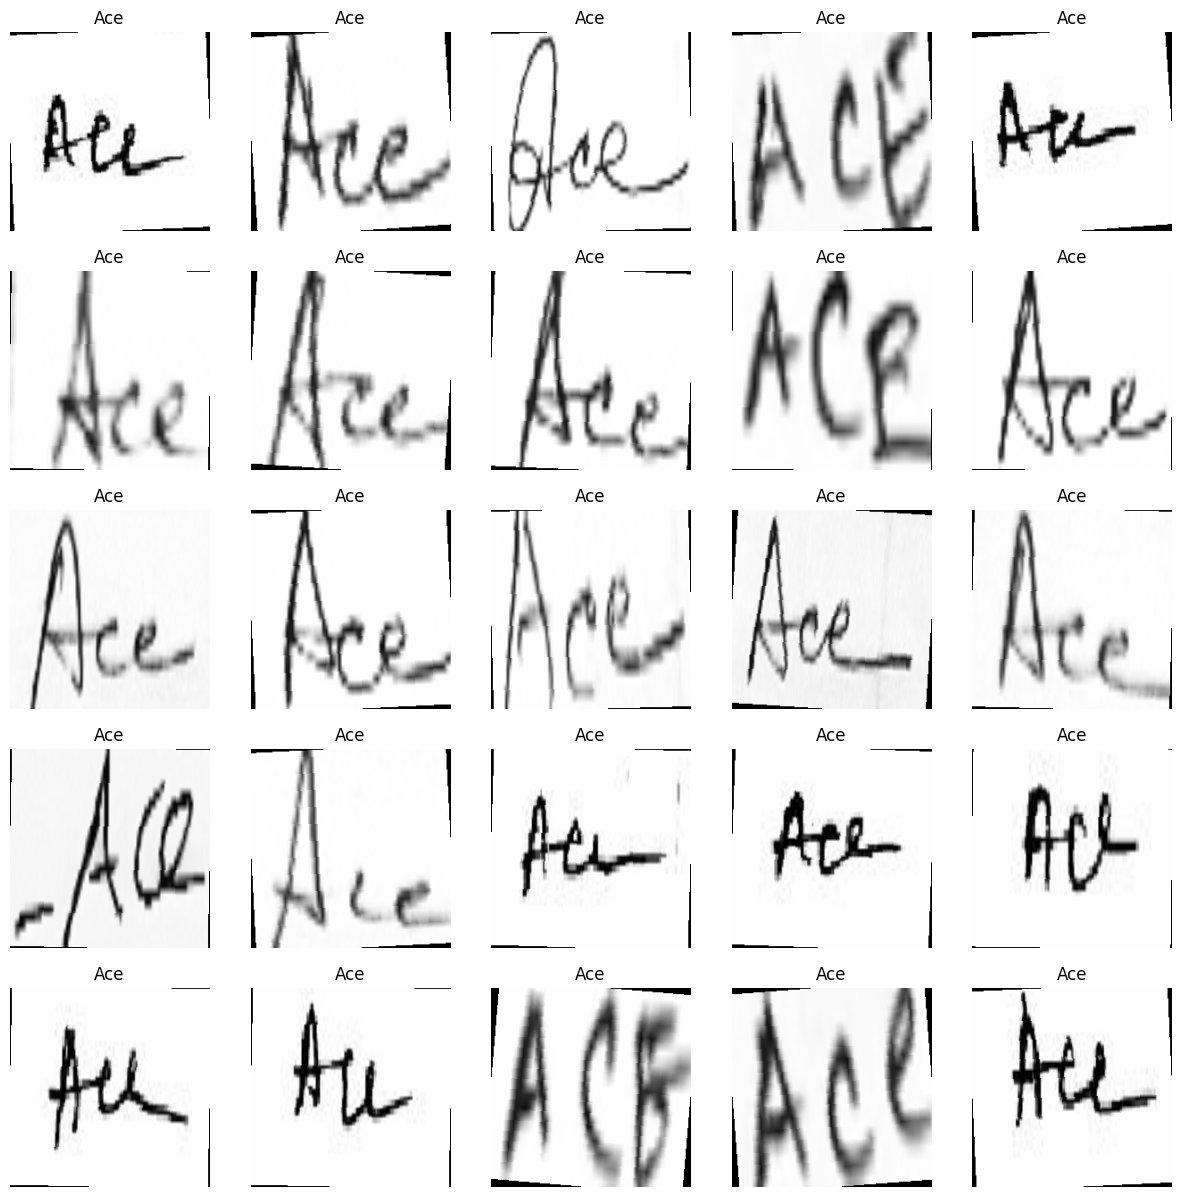

In [16]:
# Definimos el numero de imagenes a mostrar
N_IMAGES = 25

# Juntamos la imagen y su clase de los datos de entrenamiento y los guardamos
images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

# Guardamos las clases
classes = test_data.classes

# Las mostramos
plot_images(images, labels, classes)

In [17]:
# Usaremos el modelo de ResNet50, ya que presenta una buena capacidad de capturar caracteristicas mas complejas sin un costo computacional exorbitante, 
# es por esto que es una de la mas populares en problemas de vision por computadora

# Esta configuracion contiene 50 capas, tambien usa bloques de atajo con una combinacion de capas convolucionales de 1x1, 3x3 y otra vez 1x1

# Modelo base de ResNet
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [18]:
# El Bottleneck bloque es necesario añadirlo ya que este nos permite obtener las configuraciones de ResNet50, ResNet101 and ResNet152
# El bloque esta conformadio por una capa convolucional de 1x1, luego otra de 3x3 y otra de 1x1
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [19]:
# Creamos la forma de la configuracion que le pasaremos al modelo que almacenara el bloque a usar (Basicblock o Bottleneck), el numero de bloques en cada capa y
# el numero de canales en cada capa
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [20]:
# Definimos la configuracion del ResNet50
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

In [21]:
# Debido a nuestra pequeña cantidad de imagenes de entrenamiento, usaremos un modelo pre-entrenado en el dataset de ImageNet, lo que nos facilitara enfocarlo en nuestro caso
pretrained_model = models.resnet50(pretrained = True)

c:\Users\Equipo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Equipo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
# Podemos observar el modelo preentrenado
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
# Las clases de output del modelo entrenado son 1000, asi que crearemos una nueva capa lineal con las dimensiones de nuestras clases de salida

# Extraemos las features del modelo preentrenado y la dimension de nuestras clases de salida, es decir 78
IN_FEATURES = pretrained_model.fc.in_features
OUTPUT_DIM = len(test_data.classes)

# La convertimos a una capa linear
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

In [24]:
# Reemplazamos la capa lineal del modelo pre entrenado con la nuestra, inicializada aleatoriamente
pretrained_model.fc = fc

In [25]:
# Debido a que el modelo pre entrenado de torchvision no tiene un output intermediario para analisis
# Usaremos nuestro propio modelo declarado anteriormente para el analisis, copiando los parametros pre entrenados a nuestro modelo

# Inicializamos una instancia de nuestro modelo
model = ResNet(resnet50_config, OUTPUT_DIM)

In [26]:
# Cargamos los parametros pre entrenados a nuestro modelo
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [27]:
# Tambien podemos ver el numero de parametros que hemos pasado y que contiene nuestro modelo
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'El modelo tiene {count_parameters(model):,} parametros entrenables')

El modelo tiene 23,667,854 parametros entrenables


In [28]:
# Para el entrenamiento de nuestro modelo, usaremos un learning rate finder para encontrar la mejor taza de aprendizaje para nuestro modelo

# Iniciamos una tasa de aprendizaje baja 
START_LR = 1e-7

# Establecemos un optimizador, en este caso elegiremos ADAM ya que suele funcionar bien en la mayoria de problemas, trabaja bien con caracteristicas raras,
# y no requiere muchos ajustes manuales de hiperparametros lo que lo hace sencillo de aplicar
optimizer = optim.Adam(model.parameters(), lr=START_LR)

# Definimos en donde se ejecuataran las operaciones, si esta disponible CUDA (la plataforma de computacion paralela de NVIDIA necesaria para usar GPUs)
# usara la GPU para acelerar calculos, si no, usara la CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Definimos el criterion, una funcion de perdida que calculara la perdida en el entrenamiento de nuestros datos
criterion = nn.CrossEntropyLoss()

# Enviamos el modelo al dispositivo que lo ejecutara
model = model.to(device)

# Tambien enviamos el criterio, que es la funcion que nos ayudara a analizar el rendimiento de nuestro modelo
criterion = criterion.to(device)

In [29]:
# Definimos el buscador de tazas de aprendizaje el cual nos ayudara a calcular la mejor taza de aprendizaje para nuestro modelo
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [31]:
# Hacemos una prueba para definir nuestra taza de aprendizaje
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [32]:
# Creamos una funcion la cual nos grafique los reusltados obtenidos del buscador de taza de aprendizaje
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

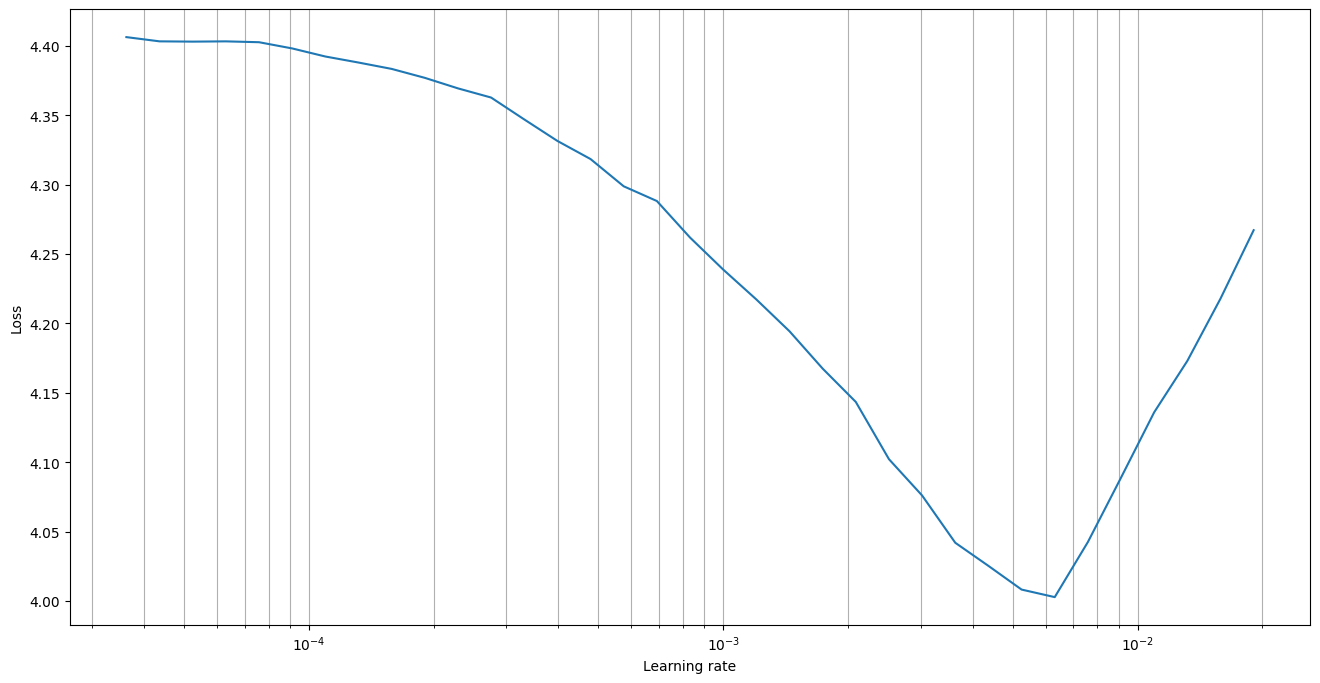

In [33]:
# Lo ejecutamos
plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

In [34]:
# Usaremos 1x10^-3 como taza de aprendizaje para entrenar nuestro modelo ya que esta mas o menos en la mitad de la caida de la perdida
FOUND_LR = 1e-3

params = [
    {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
    {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
    {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
    {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
    {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
    {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
    {'params': model.fc.parameters()}
]


optimizer = optim.Adam(params, lr = FOUND_LR)

In [35]:
# Seteamos el one cycle learning rate scheduler para ajustar la taza de aprendizaje durante el entrenamiento

# Numero de epochs de entrenamiento
EPOCHS = 10

# Numero de pasos por epoch, que son la cantidad de elementos enviados por el iterador
STEPS_PER_EPOCH = len(train_iterator)

# El total de pasos que se dara en el entrenamiento lo tenemos al multiplicar el numero de epochs por el numero de pasos por epoch
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

# Definimos la tasa de aprendizaje maxima
MAX_LRS = [p['lr'] for p in optimizer.param_groups]

# Definimos el scheduler
scheduler = lr_scheduler.OneCycleLR(optimizer,
                                     max_lr = MAX_LRS,
                                     total_steps = TOTAL_STEPS)

In [36]:
# Tambien implementaremos top-k accuracy, que nos ayudara a ver el rendimiento de nuestro modelo en las k clases mas probables
# Lo que hace es que la prediccion es considerada correcta si esta en el top-k de las clases mas probables
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [37]:
# Ahora definimos la funcion de entrenar
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    # Variables para almacenar la perdida y la exactitud
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    # Ponemos el modelo a entrenamiento
    model.train()
    
    # Para cada imagen con su etiqueta en el iterador
    for (x, y) in iterator:
        
        # Mueve los datos al dispositivo que ejecutara las operaciones
        x = x.to(device)
        y = y.to(device)
        
        # Reinicia los gradientes, ya que pytorch por defecto acumula los gradientes en cada paso de optimizacion
        optimizer.zero_grad()

        # Calcula la prediccion         
        y_pred, _ = model(x)
        
        # Calcula la perdida entre las predicciones y las etiquetas reales usando la funcion de perdida
        loss = criterion(y_pred, y)
        
        # Calcula la exactitud usando la funcion de top-k accuracy
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        # Calcula los gradientes de perdida con respecto a los parametros del modelo
        loss.backward()
        
        # Actualiza los parametros del modelo
        optimizer.step()
        
        # Actualiza la taza de aprendizaje
        scheduler.step()
        
        # Acumula la pérdida y las precisiones del lote actual a las variables
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()

    # Calcula la pérdida y las precisiones medias de la época dividiendo las sumas acumuladas por el número de lotes en el iterador.    
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [38]:
# La funcion de evaluacion es parecida a la funcion de entrenamiento, pero no actualiza los parametros del modelo
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [39]:
# Funcion para que nos diga el tiempo que una epoch ha tomado
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [40]:
# Entrenamos el modelo

# Inicializamos las variables para guardar la mejor perdida
best_valid_loss = float('inf')

# Para cada epoch
for epoch in range(EPOCHS):
    
    # Guardamos el tiempo de inicio que usaremos para medir el tiempo transcurrido
    start_time = time.monotonic()
    
    # Entrenamos y evaluamos el modelo
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, validation_iterator, criterion, device)
    
    # Si la perdida de validacion es mejor que la mejor perdida guardada, guardamos el modelo
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    # Guardamos el tiempo de fin
    end_time = time.monotonic()

    # Calculamos el tiempo que ha tomado la epoch
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 13m 52s
	Train Loss: 4.200 | Train Acc @1:   6.74% | Train Acc @5:  21.35%
	Valid Loss: 3.419 | Valid Acc @1:  26.40% | Valid Acc @5:  52.60%
Epoch: 02 | Epoch Time: 12m 6s
	Train Loss: 2.515 | Train Acc @1:  45.25% | Train Acc @5:  73.50%
	Valid Loss: 1.544 | Valid Acc @1:  60.54% | Valid Acc @5:  87.86%
Epoch: 03 | Epoch Time: 12m 20s
	Train Loss: 0.744 | Train Acc @1:  83.06% | Train Acc @5:  96.05%
	Valid Loss: 0.731 | Valid Acc @1:  81.21% | Valid Acc @5:  95.31%
Epoch: 04 | Epoch Time: 12m 23s
	Train Loss: 0.250 | Train Acc @1:  94.50% | Train Acc @5:  99.04%
	Valid Loss: 0.528 | Valid Acc @1:  88.46% | Valid Acc @5:  97.12%
Epoch: 05 | Epoch Time: 12m 23s
	Train Loss: 0.104 | Train Acc @1:  97.81% | Train Acc @5:  99.87%
	Valid Loss: 0.386 | Valid Acc @1:  90.38% | Valid Acc @5:  97.12%
Epoch: 06 | Epoch Time: 12m 21s
	Train Loss: 0.040 | Train Acc @1:  99.30% | Train Acc @5:  99.97%
	Valid Loss: 0.281 | Valid Acc @1:  93.03% | Valid Acc @5:  97.84%
Epoch

In [41]:
# Evaluamos el modelo en el conjunto de testeo

# Cargamos el modelo con la mejor perdida
model.load_state_dict(torch.load('tut5-model.pt'))

# Evaluamos el modelo en el conjunto de testeo
test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

Test Loss: 0.523 | Test Acc @1:  88.94% | Test Acc @5:  96.03%


In [42]:
# Ahora pasaremos a examinar el modelo y las predicciones 

# Funcion para obtener las predicciones de un conjunto de datos
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [43]:
images, labels, probs = get_predictions(model, test_iterator)

In [44]:
# Obtenemos las predicciones
pred_labels = torch.argmax(probs, 1)

In [45]:
# Funcion para graficar la matriz de confusion, donde la diagonal principal tiene que ser la mas oscura que el resto de la matriz
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (50, 50))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels = classes)
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)

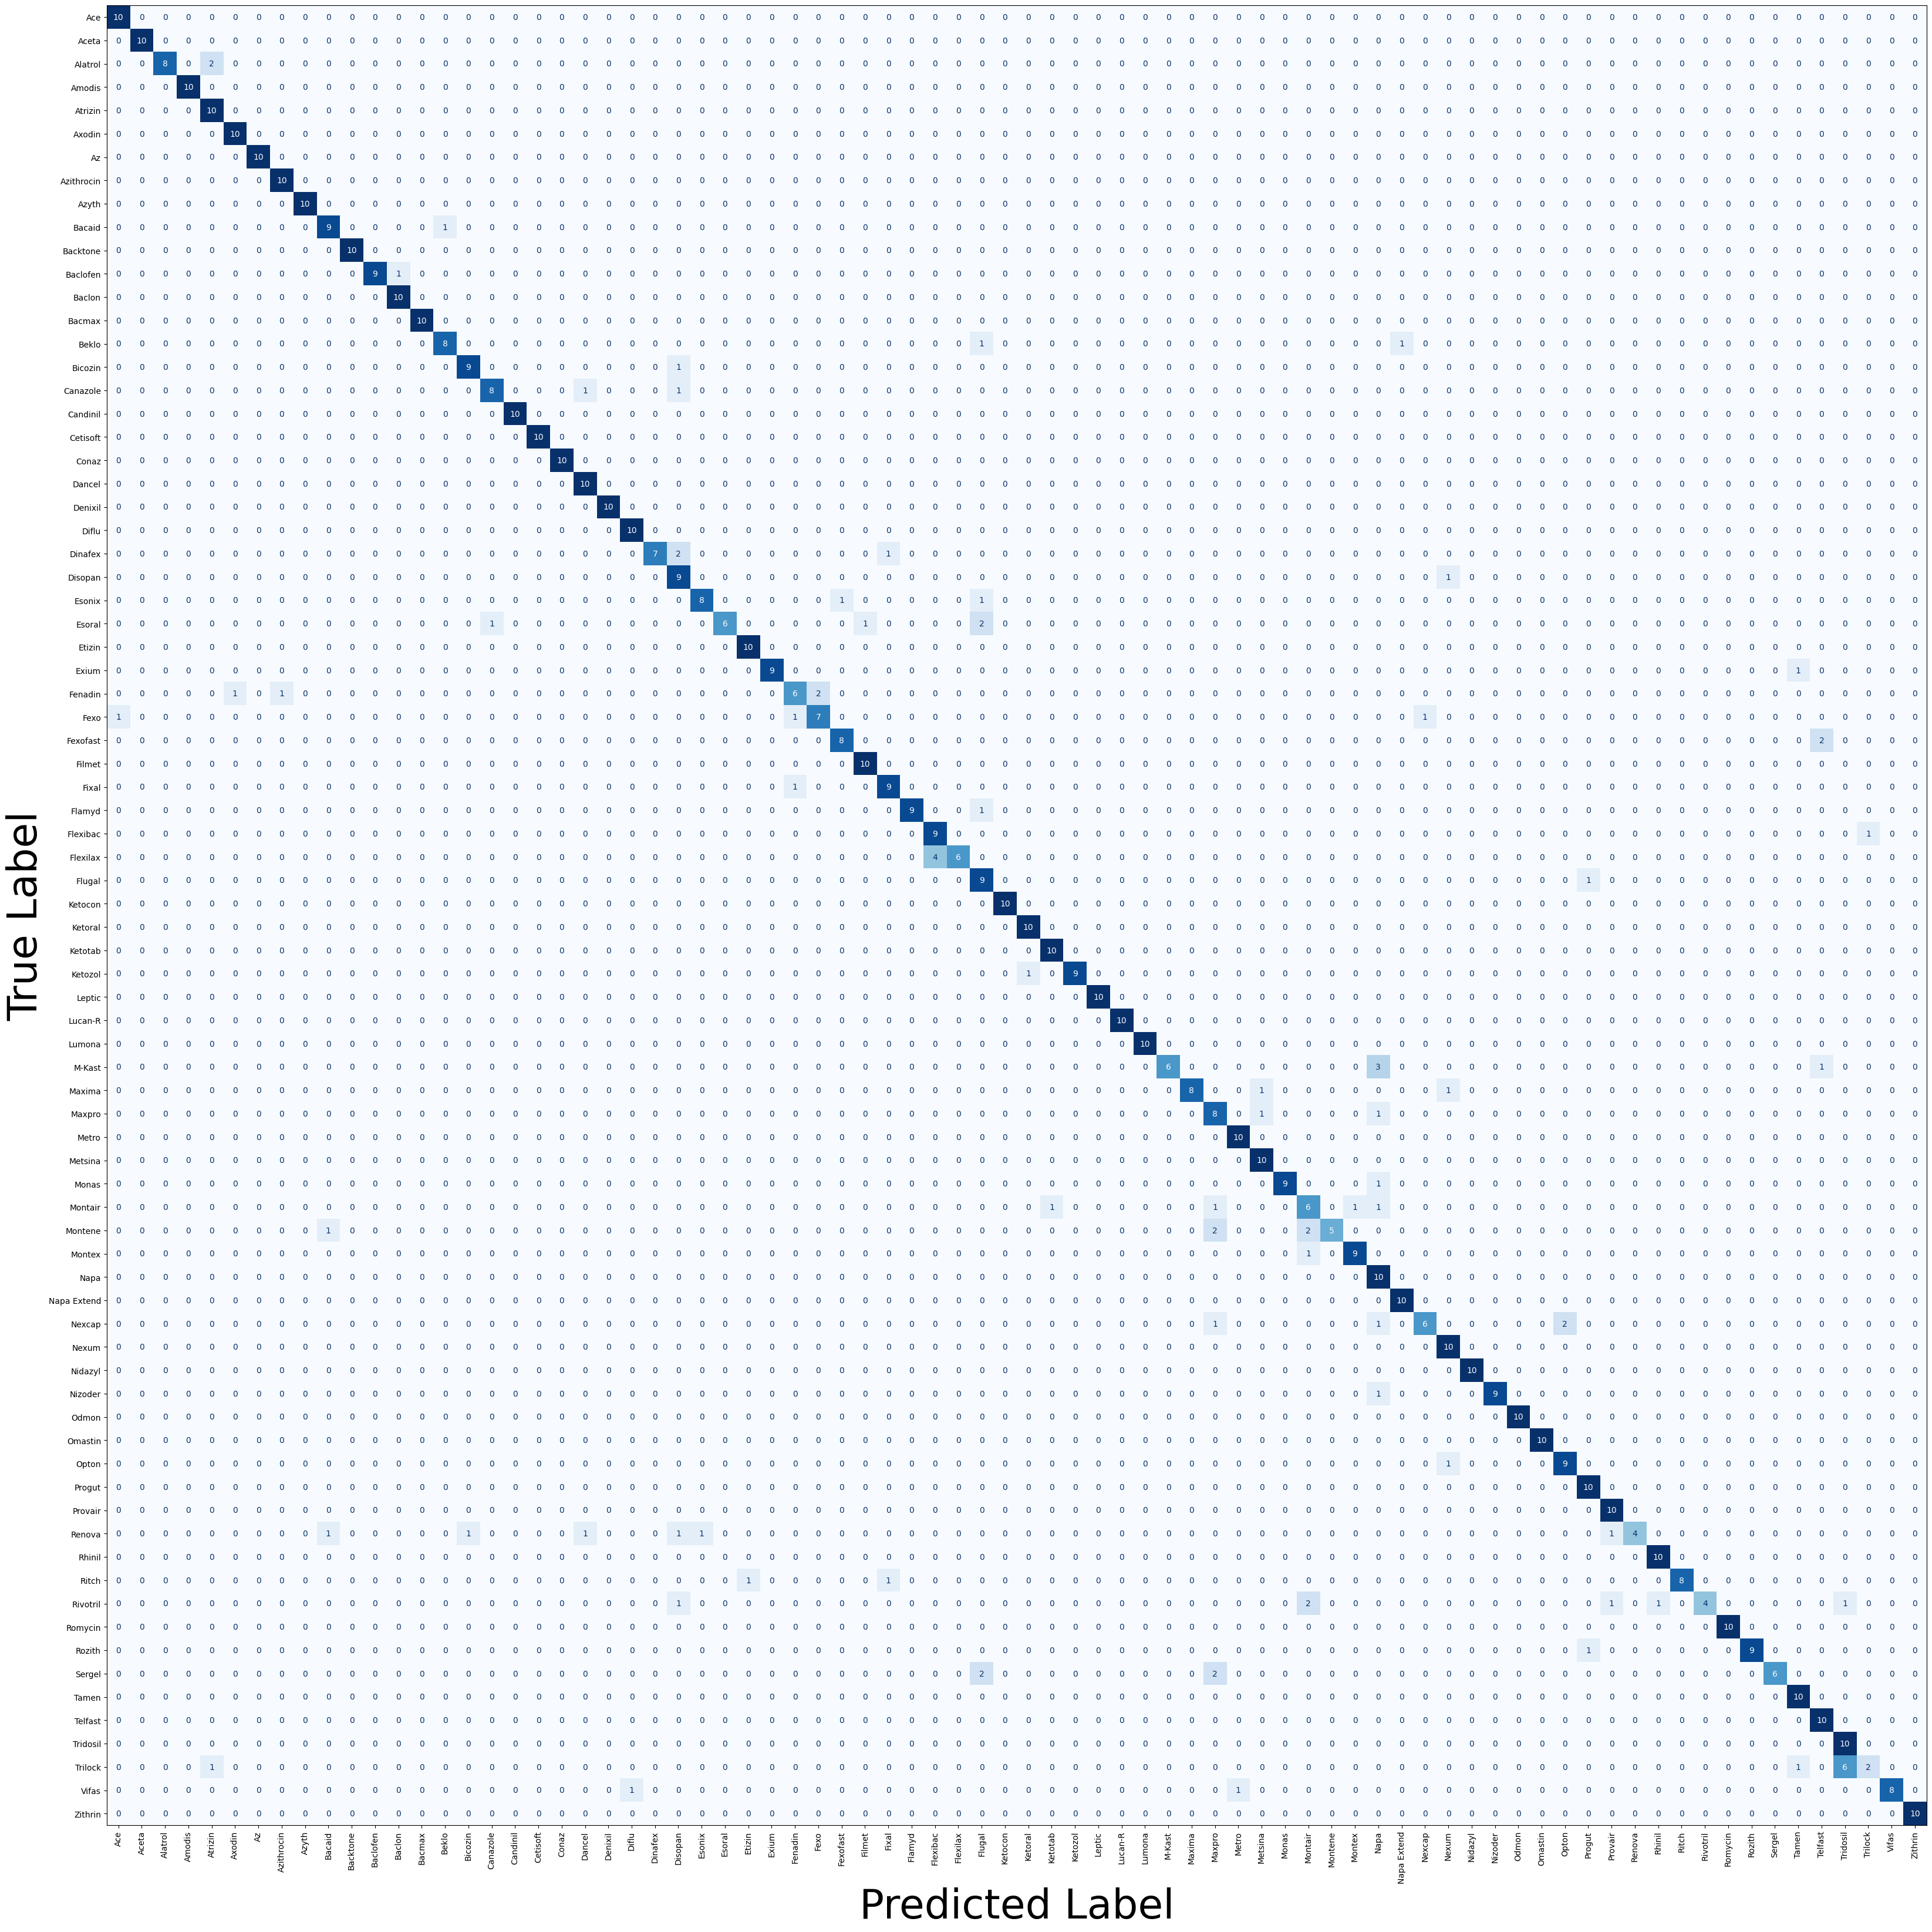

In [46]:
plot_confusion_matrix(labels, pred_labels, classes)

In [47]:
# Podemos sacar las predicciones correctas para filtrarlas y filtrar las predicciones incorrectas 

# Obtenemos la predicciones correctas
corrects = torch.eq(labels, pred_labels)

In [48]:
# Obtenemos las inconrrectas
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [49]:
# Funcion para mostrar las predicciones incorrectas con su etiqueta predecida y original
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

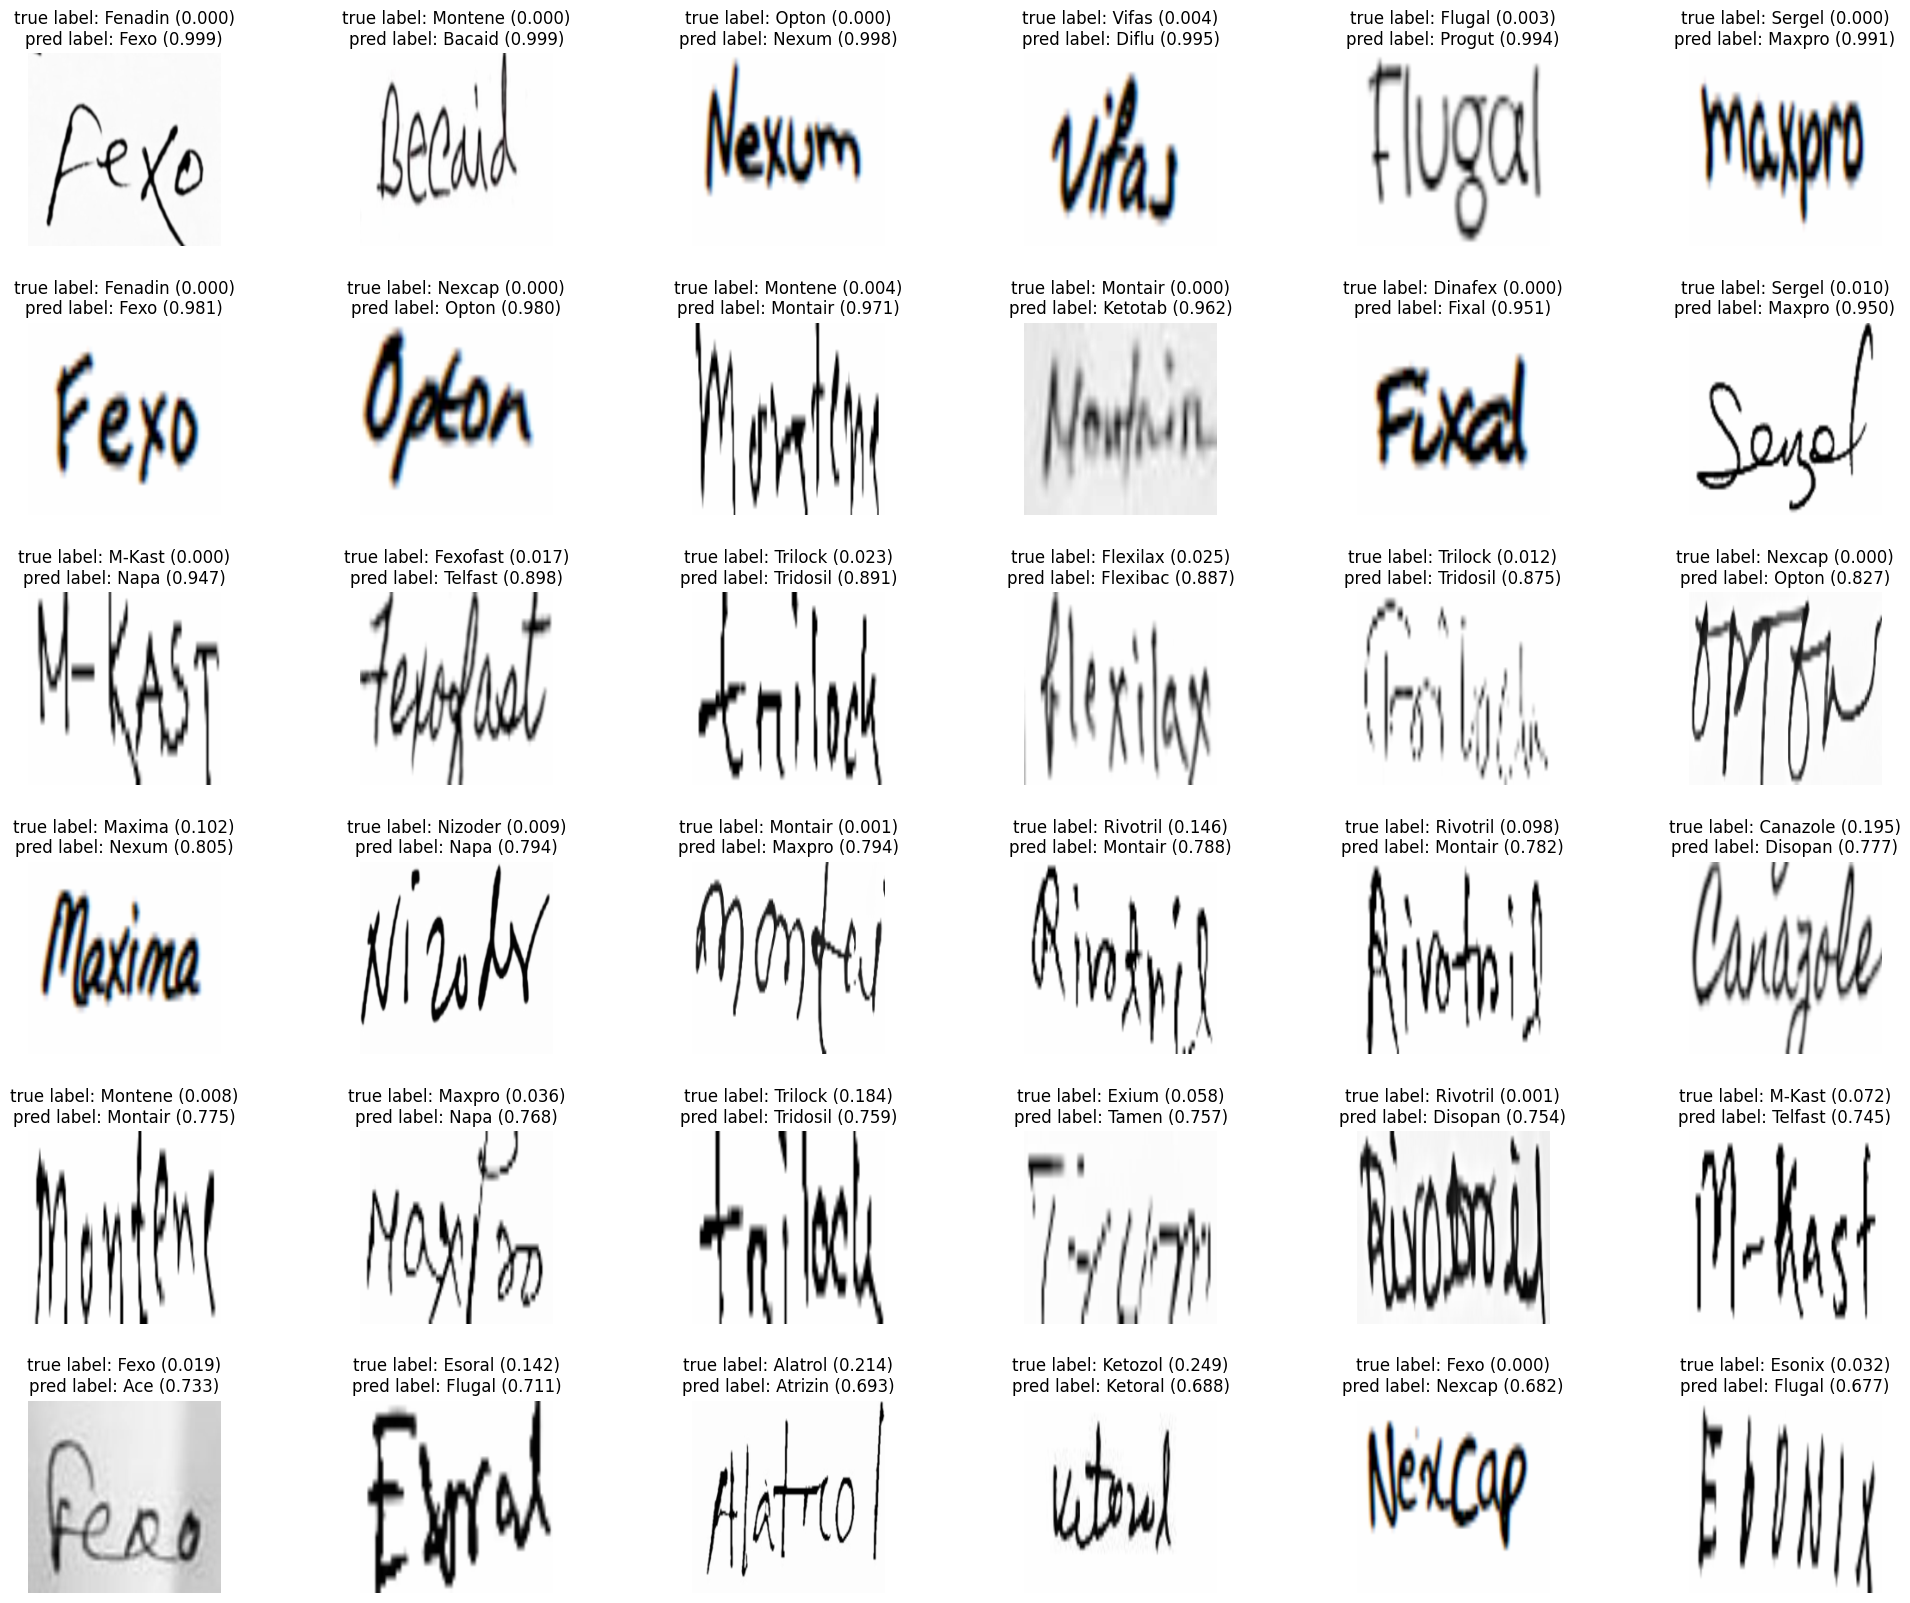

In [50]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

In [54]:
import onnx

# Exportamos el modelo en formato ONNX, lo que nos permitira usarlo en varios formatos que soporten, los cuales son muchos mas que pytorch

# Creamos un input dummy para el modelo
dummy_x = torch.randn(32, 3, 224, 224)

# Exportamos el modelo
torch.onnx.export(model,
                  dummy_x,
                  'resnet50.onnx',
                  export_params = True,
                  do_constant_folding=True,
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={'input' : {0 : 'batch_size'},
                                'output' : {0 : 'batch_size'}})


In [52]:
# Video onnx: https://www.youtube.com/watch?v=JuQz-SFN8CY